## 13-SAC

#### DDPG问题：
训练非常不稳定，收敛性较差，对超参数比较敏感，也难以适应不同的复杂环境

## SAC最大熵
最大熵强化学习背后的核心思想是，除了最大化期望回报外，还要最大化策略的熵，从而鼓励策略探索更多的行为，目前，在无模型的强化学习算法中，SAC 是一个非常高效的算法，它学习一个随机性策略，在不少标准环境中取得了领先的成绩。

### 1.最大熵强化学习
**最大熵强化学习（maximum entropy RL）** 的思想就是除了要最大化累积奖励，还要使得策略更加随机，如此强化学习的目标中就加入了一项熵的正则化项。在强化学习的背景下，策略的熵可以被认为是选择不同动作的不确定性
> 为什么要高熵(不确定性)？——因为真实环境了解不足的情况下，更加随机的除了也有助于帮助更好地探索环境，因此可以避免过早收敛到局部，或者在环境发生变化时更快适应

---

### 2.Soft策略迭代
由于目标函数发生了变化，目标需要使用Q(s,a)，此时手中有 Soft 贝尔曼方程：
$$
Q\left(s_{t}, a_{t}\right)=r\left(s_{t}, a_{t}\right)+\gamma \mathbb{E}_{s_{t+1}}\left[V\left(s_{t+1}\right)\right]
$$
于是，最大熵策略将状态的价值确定为奖励+熵:
$$
V\left(s_{t}\right)=\mathbb{E}_{a_{t} \sim \pi}\left[Q\left(s_{t}, a_{t}\right)-\alpha \log \pi\left(a_{t} \mid s_{t}\right)\right]=\mathbb{E}_{a_{t} \sim \pi}\left[Q\left(s_{t}, a_{t}\right)\right]+H\left(\pi\left(\cdot \mid s_{t}\right)\right)
$$
其中$H$表示熵，$\alpha$是一个权重参数，被称为"温度"——决定了奖励与熵之间的平衡

根据该 Soft 贝尔曼方程，在有限的状态和动作空间情况下，Soft 策略评估可以收敛到策$\pi$的 SoftQ 函数，(见附录)用指数形式策略:
$\pi^{\prime}(a \mid s) \propto \exp \left(\frac{1}{\alpha} Q^{\pi_{\text {old }}}(s, a)\right)$，
直接最大化上述目标可能在计算上不是很实际，尤其是对于策略改进来说，于是使用KL散度：
$$
\pi_{\text {new }}=\arg \min _{\pi^{\prime}} D_{K L}\left(\pi^{\prime}(\cdot \mid s), \frac{\exp \left(\frac{1}{\alpha} Q^{\pi_{\text {old }}}(s, \cdot)\right)}{Z^{\pi_{\text {old }}}(s, \cdot)}\right)
$$
其中$Z^{\pi_{\text {old }}}(s, \cdot)$是一个归一化常数，确保$\pi_{new}$是一个有效的策略分布

---

### 3.SAC
重复交替使用 Soft 策略评估和 Soft 策略提升，最终策略可以收敛到最大熵强化学习目标中的最优策略。但该 Soft 策略迭代方法只适用于 **表格型（tabular）** 设置的情况，即状态空间和动作空间是有限的情况。
在连续空间下，我们需要通过参数化函数Q和策略$\pi$来进行类似迭代：

在 SAC 算法中，我们为两个动作价值函数Q（参数分别为和$\omega_1$和$\omega_2$）和一个策略函数$\pi$（参数为$\theta$）建模。基于 Double DQN 的思想，SAC 使用两个Q网络，但每次用网络时会挑选一个Q值小的网络，从而缓解值过高估计的问题。任意一个函数的损失函数为：

##### Q损失函数
$$
\begin{aligned} L_{Q}(\omega) & =\mathbb{E}_{\left(s_{t}, a_{t}, r_{t}, s_{t+1}\right) \sim R}\left[\frac{1}{2}\left(Q_{\omega}\left(s_{t}, a_{t}\right)-\left(r_{t}+\gamma V_{\omega^{-}}\left(s_{t+1}\right)\right)\right)^{2}\right] \\ & =\mathbb{E}_{\left(s_{t}, a_{t}, r_{t}, s_{t+1}\right) \sim R, a_{t+1} \sim \pi_{\theta}\left(\cdot \mid s_{t+1}\right)}\left[\frac{1}{2}\left(Q_{\omega}\left(s_{t}, a_{t}\right)-\left(r_{t}+\gamma\left(\min _{j=1,2} Q_{\omega_{j}^{-}}\left(s_{t+1}, a_{t+1}\right)-\alpha \log \pi\left(a_{t+1} \mid s_{t+1}\right)\right)\right)\right)^{2}\right]\end{aligned}
$$
其中R是策略过去收集的数据->SAC为离线策略算法，同样使用了目标网络

##### $\pi$损失函数
$\pi$损失函数由 KL 散度得到，化简后为：
$$
L_{\pi}(\theta)=\mathbb{E}_{s_{t} \sim R, a_{t} \sim \pi_{\theta}}\left[\alpha \log \left(\pi_{\theta}\left(a_{t} \mid s_{t}\right)\right)-Q_{\omega}\left(s_{t}, a_{t}\right)\right]
$$
其实不用KL解释，可以直接理解为 **最大化函数V**，因为$V\left(s_{t}\right)=\mathbb{E}_{a_{t} \sim \pi}\left[Q\left(s_{t}, a_{t}\right)-\alpha \log \pi\left(a_{t} \mid s_{t}\right)\right]$

##### 重参数化技巧
众所周知，DDPG那样的确定性策略很多时候并不好用，因为它总是对于给定的状态产生相同的动作，这限制了智能体探索状态空间的能力，所以SAC的策略输出高斯分布的均值和标准差，然后再去采样。
> 从模型输出的高斯分布中采样动作是一个随机过程，它引入了不确定性，这使得梯度无法通过采样过程回传。这样，随机性仅在从标准正态分布的采样中引入，而转换是确定性的，并且可以关于 $\mu$ 和 $\sigma$ 微分：

**重参数化技巧（reparameterization trick）** 是解决这个问题的一种方法。它的基本思想是改变问题的形式，将不确定性从模型参数中解耦。从标准正态分布 $\mathcal{N}(0, 1)$ 中采样，然后通过乘以标准差 $\sigma$ 并加上均值 $\mu$ 来转换样本，于是改写策略损失函数：
$$
L_{\pi}(\theta)=\mathbb{E}_{s_{t} \sim R, \epsilon_{t} \sim \mathcal{N}}\left[\alpha \log \left(\pi_{\theta}\left(f_{\theta}\left(\epsilon_{t} ; s_{t}\right) \mid s_{t}\right)\right)-\min _{j=1,2} Q_{\omega_{j}}\left(s_{t}, f_{\theta}\left(\epsilon_{t} ; s_{t}\right)\right)\right]
$$

##### 自动调整熵正则项$\alpha$
在 SAC 算法中，如何选择熵正则项的系数非常重要。在不同的状态下需要不同大小的熵：在最优动作不确定的某个状态下，熵的取值应该大一点；而在某个最优动作比较确定的状态下，熵的取值可以小一点。为了自动调整熵正则项，SAC 将强化学习的目标改写为一个带约束的优化问题：
$$
\max _{\pi} \mathbb{E}_{\pi}\left[\sum_{t} r\left(s_{t}, a_{t}\right)\right] \quad s.t. \quad \mathbb{E}_{\left(s_{t}, a_{t}\right) \sim \rho_{\pi}}\left[-\log \left(\pi_{t}\left(a_{t} \mid s_{t}\right)\right)\right] \geq \mathcal{H}_{0}
$$
也就是最大化期望回报，同时约束熵的均值大于$\mathcal{H}_{0}$ 
通过一些数学技巧化简后，得到$\alpha$的损失函数：
$$
L(\alpha)=\mathbb{E}_{s_{t} \sim R, a_{t} \sim \pi\left(\cdot \mid s_{t}\right)}\left[-\alpha \log \pi\left(a_{t} \mid s_{t}\right)-\alpha \mathcal{H}_{0}\right]
$$
即当策略的熵低于目标值$\mathcal{H}_{0} $时，训练目标 $L(\alpha)$ 会使 $\alpha$ 的值增大，进而在上述最小化损失函数$ L_{\pi}(\theta)$ 的过程中增加了策略熵对应项的重要性；而当策略的熵高于目标值 $\mathcal{H}_{0} $时，训练目标$ L(\alpha)$ 会使 $\alpha$ 的值减小，进而使得策略训练时更专注于价值提升

##### 实际计算：压根求不出熵
在连续SAC中：
```
def calc_target(self, rewards, next_states, dones):  # 计算目标Q值
    next_actions, log_prob = self.actor(next_states)
    entropy = -log_prob
```
在离散SAC中：
```
def calc_target(self, rewards, next_states, dones,truncated):
    next_probs = self.actor(next_states)
    next_log_probs = torch.log(next_probs + 1e-8)
    entropy = -torch.sum(next_probs * next_log_probs, dim=1, keepdim=True)
```
实践采用基于采样的方法来估计熵,使用这个对数概率密度来估计熵
<br>实际上，不是真正计算熵，而是使用对数概率密度作为熵的一个proxy，因为它们都是激励探索的度量。 **连续SAC其实试图最大化这个对数概率密度** 



### SAC 算法的整体思想，它的具体算法流程如下：
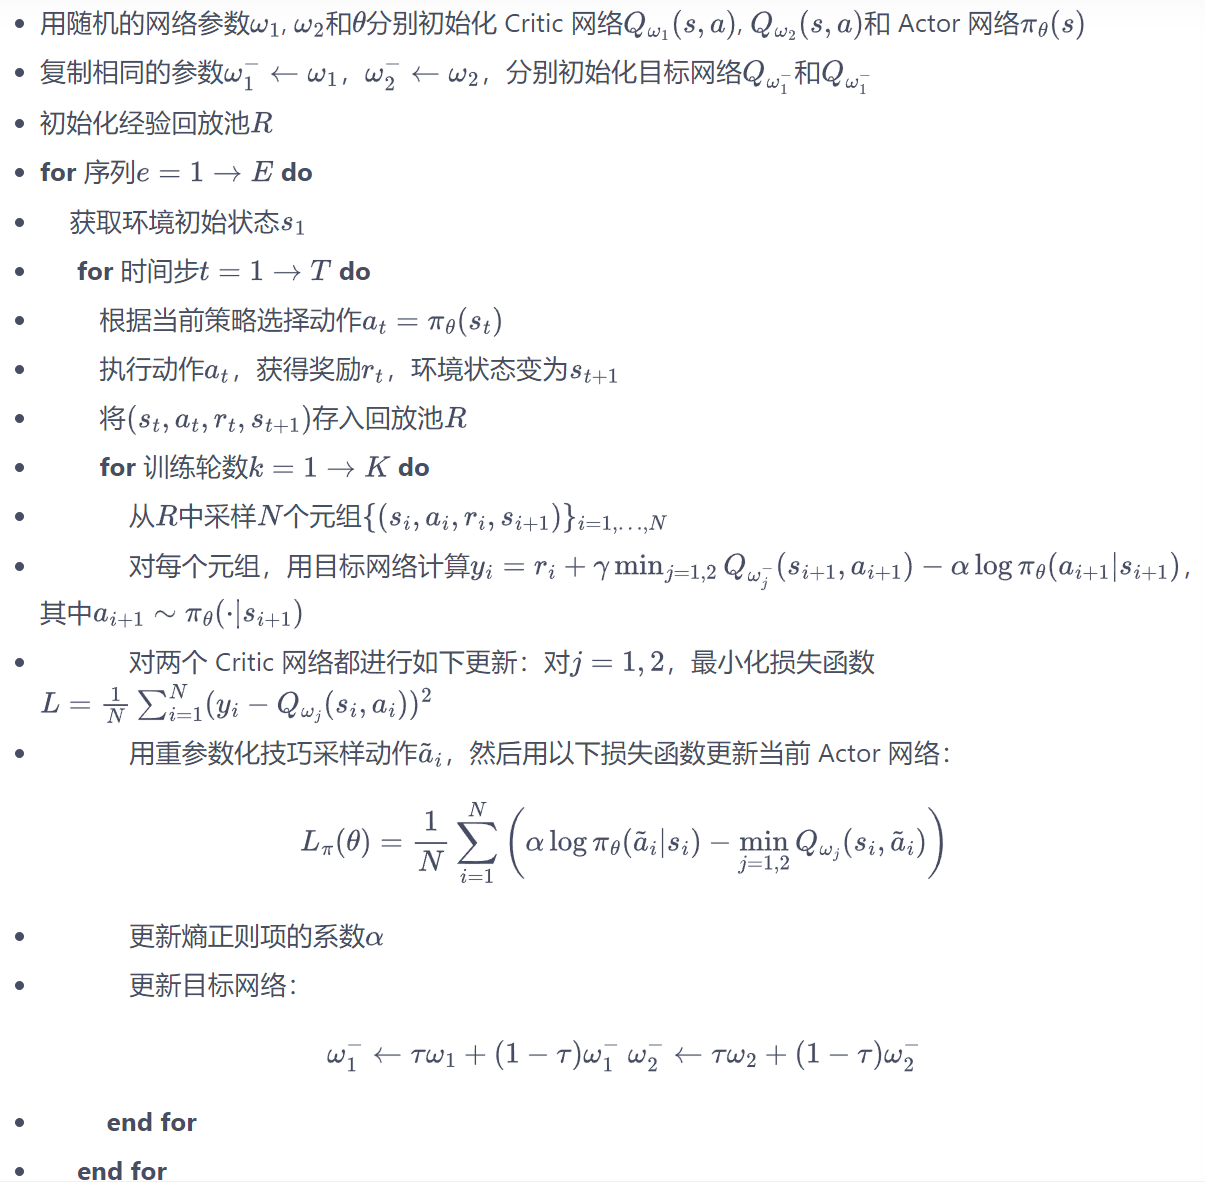

## 附录

### 1.熵
香农提出了熵的定义： **无损编码事件信息的最小平均编码长度**，即为：
$$
H = \sum_i{P(i)log_2 P(i)}
$$
可以写作：
$$
H(P)=E_{x~P}[-log P(x)]
$$
熵告诉我们信息量/罕见程度，“熵是服从某一特定概率分布事件的理论最小平均编码长度”，只要我们知道了任何事件的概率分布，我们就可以计算它的熵

#### |CEM交叉熵损失函数
交叉熵用作二分类损失函数，用于衡量两个分布的接近程度：
<br>假设预测分布为Q，真实分布为P，则可以在期望时用H(P,Q)，用P计算期望，用Q计算编码长度：
$$
H(P,Q)=E_{x~P}[-log Q(x)]
$$
其中Q1，Q2可以是学习的两个预测，可以用H(P1,Q1)和H(P1,Q2)来衡量学习效果。注意：因此H(Q,P)不等于H(P,Q)
> 交叉熵目标：假如估计完美，Q=P。则有$H(P,Q)=H(P)$
因为熵是"理论上的平均最小编码长度"所以交叉熵只可能大于等于熵，所以对于交叉熵来说，目标肯定是越小越好。

#### |二分类交叉熵
假设预测猫狗，因为$P(cat)=P(1-dog)$，所以交叉熵可以表示为$H(P, Q)=-P(c a t) \log Q(c a t)-(1-P(c a t)) \log (1-P(c a t))$，于是写作如下形式：
$$
\mathcal{L}(\phi)=-\mathbb{E}_{\rho_{\pi}}\left[\log D_{\phi}(s, a)\right]-\mathbb{E}_{\rho_{E}}\left[\log \left(1-D_{\phi}(s, a)\right)\right]
$$
其中$E$和$\pi$分别为专家和Agent,而$\phi$才是学习的分布，这里要注意判别器同时学习两个分布

---

### 2.指数策略何而来？
目标函数是$J(\pi') = \mathbb{E}_{a \sim \pi'}[Q^{\pi_{\text{old}}}(s, a) + \alpha \log \pi'(a|s)]$，实际上是一个关于 $\pi'(a|s)$ 的加权平均，因此写为$J(\pi') = \sum_{a} \pi'(a|s) [Q^{\pi_{\text{old}}}(s, a) + \alpha \log \pi'(a|s)]$，要想最大化该函数——
<br>需要计算 $J(\pi')$ 关于 $\pi'(a|s)$ 的导数,并找到使该导数为零的 $\pi'(a|s)$ 值
现在，我们计算偏导数：
$$
\frac{\partial J(\pi')}{\partial \pi'(a|s)} = \frac{\partial}{\partial \pi'(a|s)} \left( \pi'(a|s) [Q^{\pi_{\text{old}}}(s, a) + \alpha \log \pi'(a|s)] \right)
$$
其中$Q^{\pi_{\text{old}}}(s, a)$是作为常数存在的，因而有：
<br>$\frac{\partial J(\pi')}{\partial \pi'(a|s)} = Q^{\pi_{\text{old}}}(s, a) + \alpha \log \pi'(a|s) + \alpha$，将此导数为零给出：
$$
Q^{\pi_{\text{old}}}(s, a) + \alpha \log \pi'(a|s) + \alpha = 0
$$
这可以重新排列为：
$$
\pi'(a|s) \propto \exp\left(-\frac{1}{\alpha} Q^{\pi_{\text{old}}}(s, a)\right)
$$

---

### 3.数学技巧化简$\alpha$带约束优化
——拉格朗日数乘法<br>
这种类型的问题通常通过构造拉格朗日函数并应用拉格朗日对偶性来解决:

1. **构造拉格朗日函数**：当你有一个约束优化问题时，一种常见的方法是将约束加入目标函数，通过引入一个拉格朗日乘数，这里将熵的限制加入到目标函数中，得到以下的拉格朗日函数：
    $$
    \mathcal{L}(\pi, \alpha) = \mathbb{E}_{\pi}\left[\sum_{t} r\left(s_{t}, a_{t}\right)\right] - \alpha \left( \mathbb{E}_{\left(s_{t}, a_{t}\right) \sim \rho_{\pi}}\left[-\log \left(\pi_{t}\left(a_{t} \mid s_{t}\right)\right)\right] - \mathcal{H}_{0} \right)
    $$
    其中，$\alpha$ 是拉格朗日乘数，它确保熵的约束得到满足。请注意，我们将 $-\alpha$ 乘以熵，因为我们想要最大化回报但最小化熵的负值（即最大化熵）

2. **应用拉格朗日对偶性**：通过最小化关于 $\pi$ 的拉格朗日函数并最大化关于 $\alpha$ 的拉格朗日函数，我们可以找到原始约束优化问题的解。这通常涉及到计算梯度并使用梯度上升（对于 $\alpha$）和梯度下降（对于 $\pi$）来更新参数。
    
    在这种情况下，我们关注 $\alpha$ 的优化，因为我们想要找到 $\alpha$ 的损失函数。通过对拉格朗日函数 $\mathcal{L}(\pi, \alpha)$ 关于 $\alpha$ 求导，并设置导数为零，我们可以找到 $\alpha$ 的最优值。但是，在实际应用中，我们通常不直接设置导数为零，而是使用梯度上升来逐步调整 $\alpha$，以满足熵的约束。

    因此，$\alpha$ 的损失函数 $L(\alpha)$ 是通过从拉格朗日函数中提取与 $\alpha$ 有关的项得到的，目的是通过梯度上升来优化 $\alpha$，以确保熵保持在所需的水平 $\mathcal{H}_0$。这就是为什么 $L(\alpha)$ 看起来像是在最大化熵（或最小化熵的负值），同时确保它不低于 $\mathcal{H}_0$。

---

### 4.问题：为何要使用KL散度？
如果不使用KL散度，硬着头皮上目标函数：期望奖励+期望熵
$$
J(\theta) = \mathbb{E}_{s \sim \rho, a \sim \pi_{\theta}} \left[ Q(s, a) - \alpha \log \pi_{\theta}(a|s) \right]
$$
其中，$\rho$状态访问分布,$\alpha$温度参数
<br>计算关于$\theta$的梯度：
$$
\nabla_{\theta} J(\theta) = \mathbb{E}_{s \sim \rho, a \sim \pi_{\theta}} \left[ \nabla_{\theta} \log \pi_{\theta}(a|s) \left( Q(s, a) - \alpha \log \pi_{\theta}(a|s) \right) \right]
$$
<br>现在还要加入一个约束$\quad \mathbb{E}_{\left(s_{t}, a_{t}\right) \sim \rho_{\pi}}\left[-\log \left(\pi_{t}\left(a_{t} \mid s_{t}\right)\right)\right] \geq \mathcal{H}_{0}$直接用拉格朗日乘数，转为：



In [2]:
import random
import gymnasium as gym
import numpy as np
import torch
import torch.nn.functional as F
from torch.distributions import Normal
import rl_utils
import os

## SAC代码实践--倒立摆

# 网络
#### |注意：log_prob对数概率密度
概率密度函数（PDF）的变换规则：
随机变量 $X$，并且你应用了一个变换 $Y = g(X)$，那么 $Y$ 的PDF是：
$$
f_Y(y) = f_X(g^{-1}(y)) \left| \frac{d}{dy}g^{-1}(y) \right|
$$
其中$\tanh$ 函数的导数是 $1 - \tanh^2(x)$(即 $\tanh$ 变换的雅可比行列式)，$1e-7$ 是为了数值稳定性而添加的一个小量，以避免取对数时出现零
<br>所以才有代码：
```python
log_prob = log_prob - torch.log(1 - action.pow(2) + 1e-7)
```

---

#### |注意：dist.rsample()
1. **`dist.sample()`**:
   - 这个方法从分布中抽取样本，但这个过程是不可导的，即它阻断了梯度传播。当你调用`sample()`时，生成的样本与创建它的参数（这里是`mu`和`std`）在计算图中是分离的
   - 这意味着，在反向传播过程中，梯度无法通过`sample()`操作回传到网络的参数
2. **`dist.rsample()`**:
   - 这个方法执行所谓的“重参数化”操作，它允许从分布中抽取样本，同时保持梯度传播的能力

总之，当你需要梯度信息来更新抽样操作背后的参数时（例如，在强化学习中更新策略），你应该使用`rsample()`。如果你只是需要从分布中随机抽取样本，并不关心梯度信息，则可以使用`sample()`

In [3]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        dist = Normal(mu, std)
        # rsample()是重参数化采样, 输出一个采样值(动作), 直接sample会阻碍计算图梯度更新
        normal_sample = dist.rsample()
        log_prob = dist.log_prob(normal_sample)  # 输出的是该动作的对数概率密度
        action = torch.tanh(normal_sample)
        # action经过tanh的变换，策略不再是高斯分布，重新计算对数概率
        log_prob = log_prob - torch.log(1 - action.pow(2) + 1e-7)
        action = action * self.action_bound  # 缩放到动作空间
        return action, log_prob
    

class QValueNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

# SAC连续动作

In [ ]:
class SACContinuous:
    ''' 处理连续动作的SAC算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound, 
                 actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim, action_bound).to(device)  # 策略网络
        self.critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)  # 第一个Q网络
        self.critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)  # 第二个Q网络
        self.target_critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)  # 第一个目标Q网络
        self.target_critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)  # 第二个目标Q网络
        # 令目标Q网络的初始参数和Q网络一样
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr=critic_lr)
        # 使用alpha的log值, 可以使训练结果比较稳定
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)  # 用于控制熵的重要程度
        self.log_alpha.requires_grad = True  # 可以对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=alpha_lr)
        self.target_entropy = target_entropy  # 目标熵的大小, 原论文认为应该等于负的动作空间
        self.gamma = gamma
        self.tau = tau
        self.device = device

    def take_action(self, state) -> (int | list[float]):
        state = torch.tensor(state[np.newaxis, :], dtype=torch.float).to(self.device)
        action = [self.actor(state)[0].item()]
        return action

    def calc_target(self, rewards, next_states, dones, truncated):  # 计算目标Q值
        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob  # 熵 = -对数动作概率
        q1_value = self.target_critic_1(next_states, next_actions)
        q2_value = self.target_critic_2(next_states, next_actions)
        next_value = torch.min(q1_value, q2_value) + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones | truncated)
        return td_target

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.int).view(-1, 1).to(self.device)
        truncated = torch.tensor(transition_dict['truncated'], dtype=torch.int).view(-1, 1).to(self.device)
        # 和之前章节一样, 对倒立摆环境的奖励进行重塑以便训练
        rewards = (rewards + 8.0) / 8.0

        # 更新两个Q网络
        td_target = self.calc_target(rewards, next_states, dones, truncated)
        critic_1_loss = torch.mean(F.mse_loss(self.critic_1(states, actions), td_target.detach()))
        critic_2_loss = torch.mean(F.mse_loss(self.critic_2(states, actions), td_target.detach()))
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # 更新策略网络
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy - torch.min(q1_value, q2_value))
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # 更新alpha值
        alpha_loss = torch.mean((entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()
        
        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

# 初始化参数

In [ ]:
# 环境相关
env_name = 'Pendulum-v1'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# SAC算法相关
PATH = 'checkpoints/SAC_PDv1.pt'
actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4
total_epochs = 5
total_episodes = 100
gamma = 0.99
tau = 0.005  # 软更新参数
buffer_size = 100000
minimal_size = 1000
batch_size = 64
target_entropy = -env.action_space.shape[0]  # 原论文认为是动作空间的负数, torchrl给的默认值是-torch.prod(n_actions)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)

# 神经网络相关
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
hidden_dim = 128

# 其他
agent = SACContinuous(state_dim, hidden_dim, action_dim, action_bound, 
                      actor_lr, critic_lr, alpha_lr, target_entropy, tau, 
                      gamma, device)

# 检查点

In [ ]:
def read_ckp(ckp_path):
    if os.path.exists(ckp_path):
        checkpoint = torch.load(ckp_path)
        s_epoch = checkpoint['epoch']
        s_episode = checkpoint['episode']
        agent.actor.load_state_dict(checkpoint['actor_best_weight'])
        agent.critic_1.load_state_dict(checkpoint['critic_1_best_weight'])
        agent.critic_2.load_state_dict(checkpoint['critic_2_best_weight'])
        return_list = checkpoint['return_list']
        return s_epoch, s_episode, return_list
    else:
        s_epoch = 0
        s_episode = 0
        return_list = []
        return s_epoch, s_episode, return_list

## 读取检查点

In [ ]:
s_epoch, s_episode, return_list = read_ckp(PATH)

# 训练函数

In [ ]:
return_list = rl_utils.train_off_policy_agent(env, agent, s_epoch, total_epochs, s_episode, total_episodes, 
                                              replay_buffer, minimal_size, batch_size, return_list, PATH, 3)

# 作图

In [ ]:
rl_utils.picture_return(return_list, 'SAC', env_name)

# 演示策略

In [ ]:
test_list = rl_utils.show_gym_policy(env_name, agent, 'rgb_array', epochs=400, model_type='AC', if_return=True)

In [ ]:
view_list = rl_utils.show_gym_policy(env_name, agent, 'human', epochs=10, model_type='AC', if_return=True)

# ✅SAC基本思想

参考[https://zhuanlan.zhihu.com/p/647639991?](https://zhuanlan.zhihu.com/p/647639991?)

# SAC离散动作

效果很差，不建议运行

In [1]:
import random
import gymnasium as gym
import numpy as np
import torch
import torch.nn.functional as F
from torch.distributions import Normal
import rl_utils
import os

## 网络

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)  # 直接输出softmax


class QValueNet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class DiscretePolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_probs = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        action_probs = F.softmax(self.fc_probs(x), dim=-1)
        return action_probs

    

class QValueNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)


## SAC-离散
理论上，你可以在离散的SAC中使用一个策略网络（actor）来采样一个动作，并用一个连续的Q网络（如`QValueNetContinuous`）来评估这个特定的状态-动作对。但这样做会有几个重要的限制和问题：

1. **失去动作分布信息**:
   - 在标准的离散SAC中，Q网络为每个可能的动作输出一个Q值，这允许算法在决策时考虑整个动作空间。如果你只采样一个动作并评估它，你就失去了关于其他可能动作的Q值信息，这可能导致次优的决策。
   - 更重要的是，SAC算法是基于熵正则化的，它试图最大化策略的熵。这需要关于整个动作概率分布的信息，而不仅仅是一个采样的动作。

2. **不兼容的训练过程**:
   - SAC的训练过程涉及对Q值的期望进行优化，这需要知道所有可能动作的概率分布。如果你只对一个采样的动作评估Q值，你就不能计算这个期望，因为你失去了概率分布的其他部分。

3. **效率问题**:
   - 如果你为每个状态都只采样一个动作，那么你需要大量的采样才能充分了解整个动作空间。这是非常低效的，特别是当动作空间很大时。

4. **探索问题**:
   - SAC的一个关键特性是它能够进行有效的探索，这是通过鼓励高熵的策略来实现的。如果你只采样并评估一个动作，你的策略将倾向于重复采样高Q值的动作，从而减少探索。

In [3]:
class SAC:
    ''' 处理离散动作的SAC算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 alpha_lr, target_entropy, tau, gamma, device):
        # 策略网络
        self.actor = DiscretePolicyNet(state_dim, hidden_dim, action_dim).to(device)
        # 第一个Q网络
        self.critic_1 =QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        # 第二个Q网络
        self.critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic_1 = QValueNetContinuous(state_dim, hidden_dim,
                                         action_dim).to(device)  # 第一个目标Q网络
        self.target_critic_2 = QValueNetContinuous(state_dim, hidden_dim,
                                         action_dim).to(device)  # 第二个目标Q网络
        # 令目标Q网络的初始参数和Q网络一样
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr=critic_lr)
        # 使用alpha的log值,可以使训练结果比较稳定
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  # 可以对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=alpha_lr)
        self.target_entropy = target_entropy  # 目标熵的大小
        self.gamma = gamma
        self.tau = tau
        self.device = device
        self.action_dim = action_dim

    def gumbel_softmax_sample(self,action_probs, temperature=1):
        gumbel_noise = -torch.log(-torch.log(torch.rand_like(action_probs) + 1e-20) + 1e-20)
        return F.softmax((torch.log(action_probs + 1e-20) + gumbel_noise) / temperature, dim=-1)
    
    def take_action(self, state) -> int:
        state = torch.tensor(state[np.newaxis, :], dtype=torch.float).to(self.device)
        action_probs = self.actor(state)
        action_one_hot = self.gumbel_softmax_sample(action_probs)  
        #action = torch.argmax(action_one_hot, dim=-1)  
        #return action.item()
        y = (action_one_hot.to(self.device) - action_probs).detach() + action_probs
        return y

    # 计算目标Q值,直接用策略网络的输出概率进行期望计算
    def calc_target(self, rewards, next_states, dones, truncated):
        next_probs = self.actor(next_states)
        next_log_probs = torch.log(next_probs + 1e-8)
        entropy = -torch.sum(next_probs * next_log_probs, dim=1, keepdim=True)

        # 使用 Gumbel Softmax 采样得到近似的 one-hot 向量
        next_actions_one_hot = self.gumbel_softmax_sample(next_probs)

        # 对于连续的 Q 网络，我们需要将 one-hot 编码的动作向量转换为可以被网络接受的形式。
        # 由于你的网络是为连续动作设计的，它期望接收实数动作。因此，我们需要确定如何从 one-hot 编码动作转换。
        # 一个常见的方法是使用 one-hot 向量与动作空间的大小进行缩放，但这取决于你的环境和网络设计。
        next_actions_continuous = torch.matmul(next_actions_one_hot, torch.eye(self.action_dim).to(self.device))

        # 使用连续的动作来评估 Q 值
        q1_value = self.target_critic_1(next_states, next_actions_continuous)
        q2_value = self.target_critic_2(next_states, next_actions_continuous)

        # 选择最小的 Q 值
        min_qvalue = torch.min(q1_value, q2_value)

        next_value = min_qvalue + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones | truncated)
        return td_target



    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.int64).view(-1, 1).to(self.device)  # 动作不再是float类型
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.int).view(-1, 1).to(self.device)
        truncated = torch.tensor(transition_dict['truncated'], dtype=torch.int).view(-1, 1).to(self.device)

        # 更新两个Q网络
        td_target = self.calc_target(rewards, next_states, dones, truncated)
            # 生成 one-hot 编码的动作
        actions_one_hot = F.one_hot(actions.squeeze(-1), num_classes=self.action_dim).float()
        actions_continuous = torch.matmul(actions_one_hot, torch.eye(self.action_dim).to(self.device))
        critic_1_q_values = self.critic_1(states, actions_continuous)  # 传递动作参数
        critic_1_loss = torch.mean(F.mse_loss(critic_1_q_values, td_target.detach()))
        critic_2_q_values = self.critic_2(states, actions_continuous)  # 传递动作参数
        critic_2_loss = torch.mean(F.mse_loss(critic_2_q_values, td_target.detach()))
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # 更新策略网络
        action_probs = self.actor(states)
        action_one_hot = self.gumbel_softmax_sample(action_probs)  # 使用Gumbel-Softmax采样得到近似的one-hot向量
        log_prob = torch.log(torch.sum(action_probs * action_one_hot, dim=-1, keepdim=True) + 1e-20)
        entropy = -log_prob  # 熵 = -对数概率
        q1_value = self.critic_1(states, action_one_hot)  # 使用one-hot向量作为动作输入Q网络
        q2_value = self.critic_2(states, action_one_hot)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy - torch.min(q1_value, q2_value))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新alpha值
        alpha_loss = torch.mean((entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)


## 超参数

In [4]:
# 环境相关
env_name = 'CartPole-v1'
env = gym.make(env_name)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# SAC算法相关
PATH = 'checkpoints/SAC_CPv8.pt'
actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4
total_epochs = 12
total_episodes = 200
gamma = 0.99
tau = 0.005  # 软更新参数
buffer_size = 100000
minimal_size = 1000
batch_size = 64
target_entropy = 0.98 * (-np.log(1 / env.action_space.n))  # 离散动作目标熵, 离散SAC论文给的目标熵是0.98(-log(1/|A|))
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)

# 神经网络相关
state_dim = env.observation_space.shape[0]
hidden_dim = 128
action_dim = env.action_space.n

# 无需输入动作上限, 现在动作是离散的
agent = SAC(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, alpha_lr,
            target_entropy, tau, gamma, device)

cuda


## 读取检查点

In [5]:
def read_ckp(ckp_path):
    if os.path.exists(ckp_path):
        checkpoint = torch.load(ckp_path)
        s_epoch = checkpoint['epoch']
        s_episode = checkpoint['episode']
        agent.actor.load_state_dict(checkpoint['actor_best_weight'])
        agent.critic_1.load_state_dict(checkpoint['critic_1_best_weight'])
        agent.critic_2.load_state_dict(checkpoint['critic_2_best_weight'])
        return_list = checkpoint['return_list']
        return s_epoch, s_episode, return_list
    else:
        s_epoch = 0
        s_episode = 0
        return_list = []
        return s_epoch, s_episode, return_list

In [6]:
s_epoch, s_episode, return_list = read_ckp(PATH)

## 训练

<1/12>:   0%|          | 0/200 [00:00<?, ?it/s]

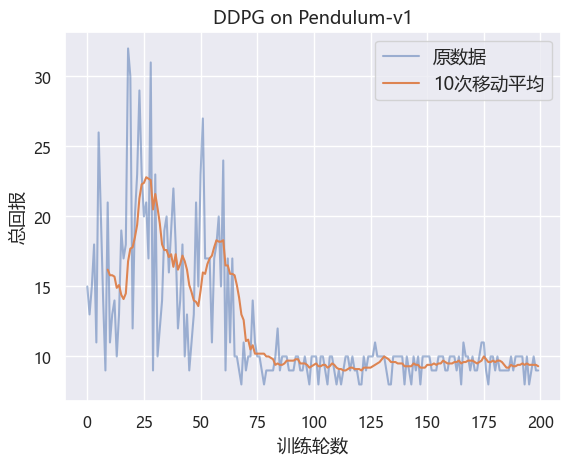

<2/12>:   0%|          | 0/200 [00:00<?, ?it/s]

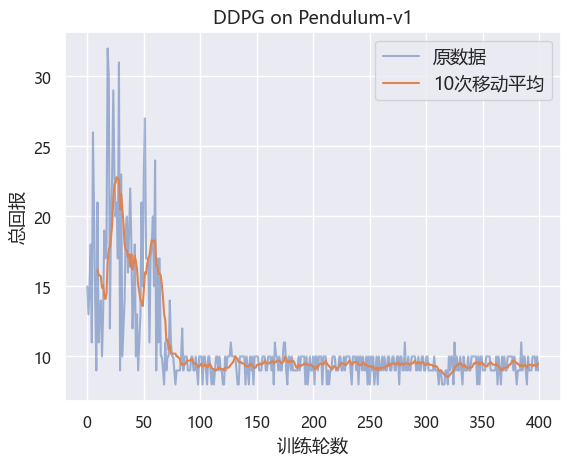

<3/12>:   0%|          | 0/200 [00:00<?, ?it/s]

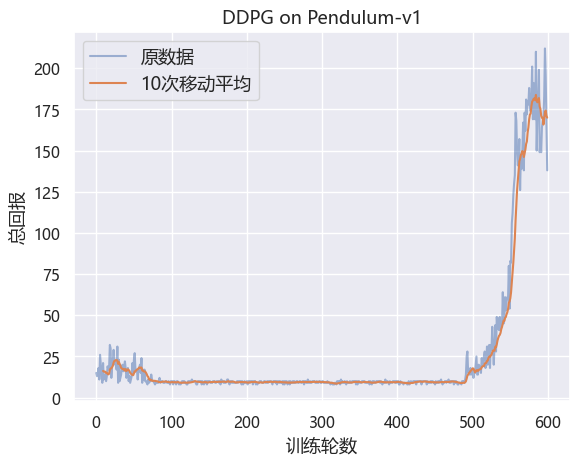

<4/12>:   0%|          | 0/200 [00:00<?, ?it/s]

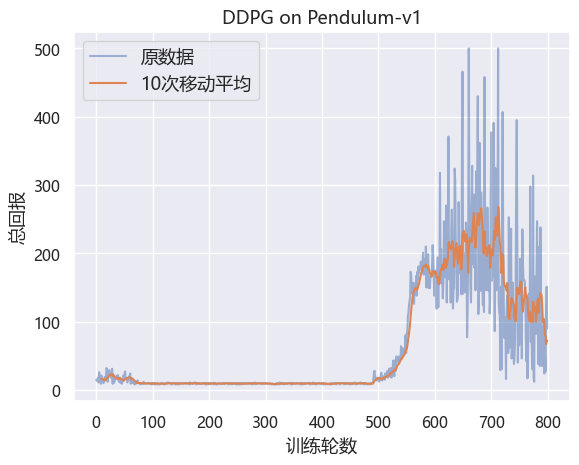

<5/12>:   0%|          | 0/200 [00:00<?, ?it/s]

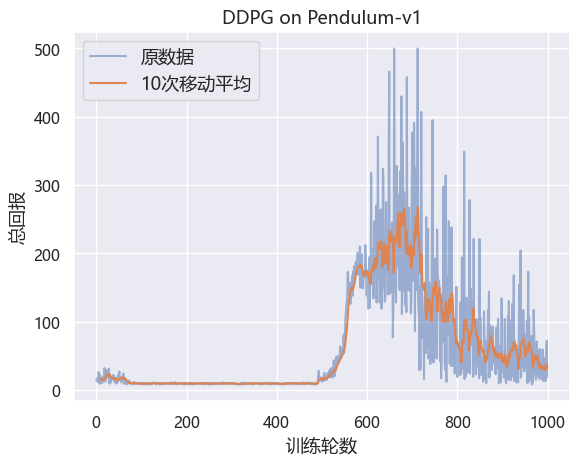

<6/12>:   0%|          | 0/200 [00:00<?, ?it/s]

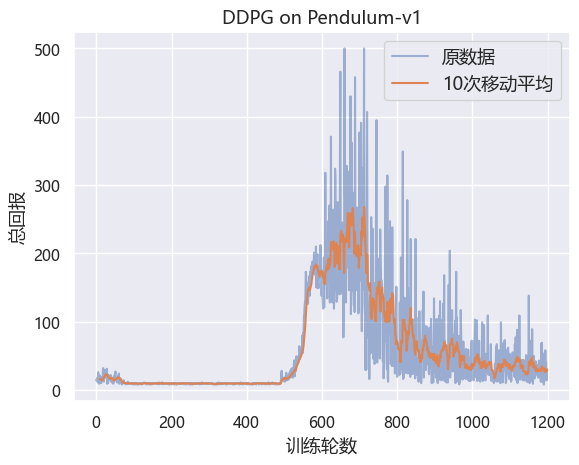

<7/12>:   0%|          | 0/200 [00:00<?, ?it/s]

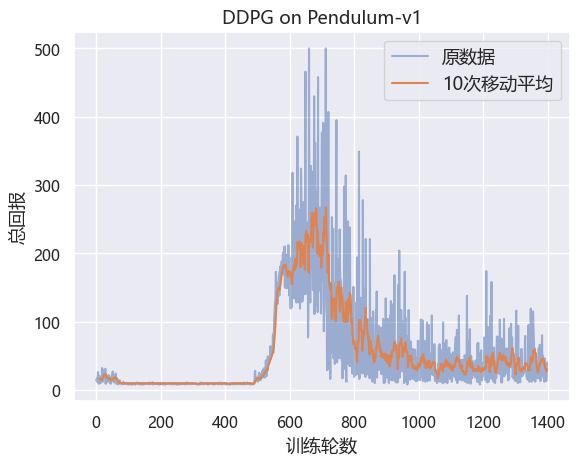

<8/12>:   0%|          | 0/200 [00:00<?, ?it/s]

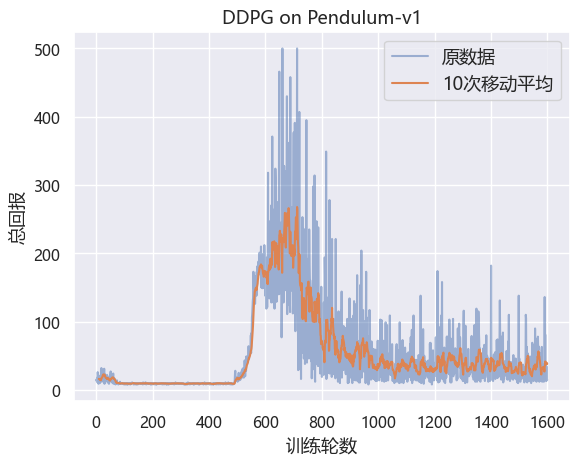

<9/12>:   0%|          | 0/200 [00:00<?, ?it/s]

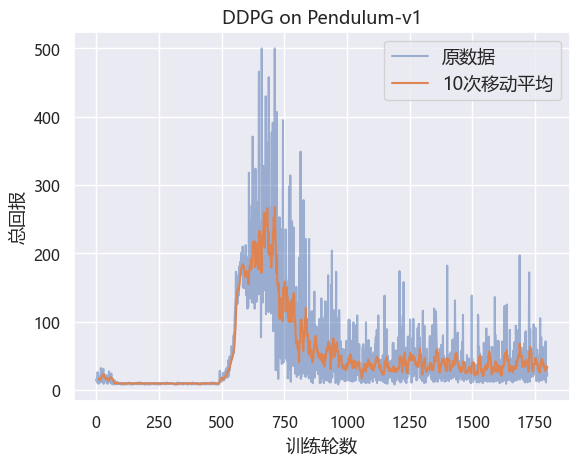

<10/12>:   0%|          | 0/200 [00:00<?, ?it/s]

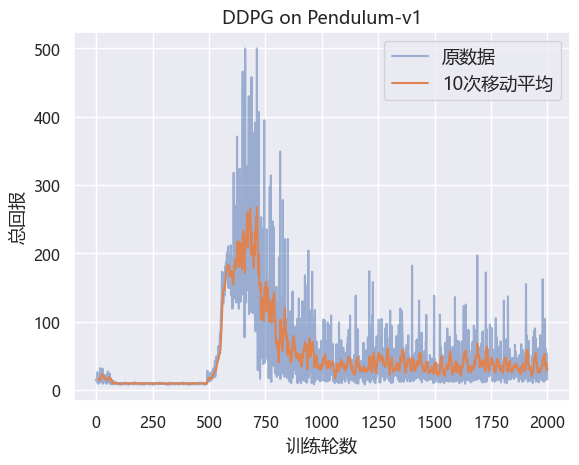

<11/12>:   0%|          | 0/200 [00:00<?, ?it/s]

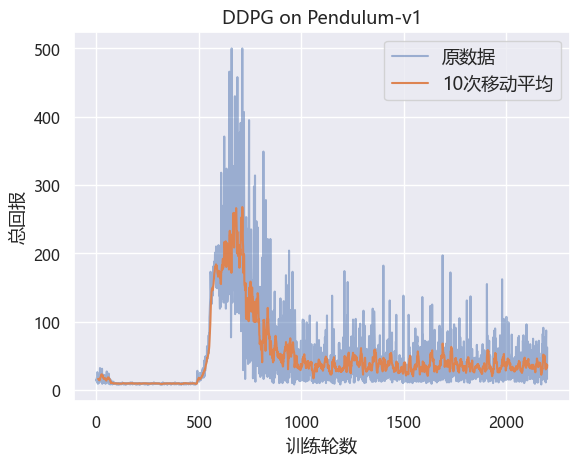

<12/12>:   0%|          | 0/200 [00:00<?, ?it/s]

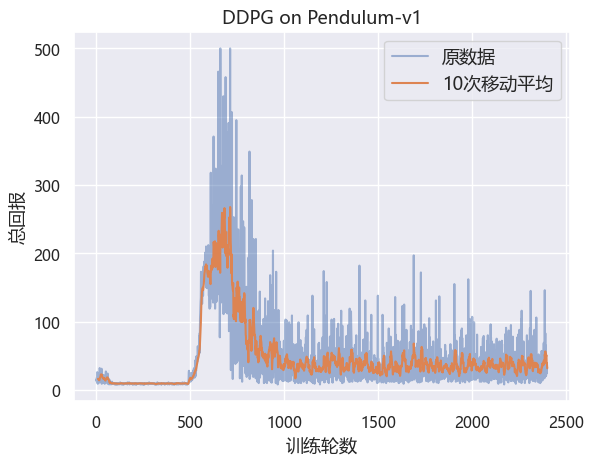

总耗时: 22分钟


: 

In [7]:
return_list = rl_utils.train_off_policy_agent(env, agent, s_epoch, total_epochs, 
                                              s_episode, total_episodes, 
                                              replay_buffer, minimal_size, batch_size, 
                                              return_list, PATH, 3)

## 作图

In [ ]:
s_epoch, s_episode, return_list = read_ckp(PATH)
rl_utils.picture_return(return_list, 'SAC', env_name)

## 演示策略

In [ ]:
test_list = rl_utils.show_gym_policy(env_name, agent, 'rgb_array', epochs=200, model_type='AC', if_return=True)

In [ ]:
rl_utils.show_gym_policy(env_name, agent, 'human', epochs=10, model_type='AC')